In [13]:
from few.waveform import FastKerrEccentricEquatorialFlux, GenerateEMRIWaveform
from few.waveform.base import SphericalHarmonicWaveformBase
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union, Callable

use_gpu = False #False if your computer sucks (mine does)

from stableemrifisher.utils import viewing_angle_partials, fplus_fcros_derivs
from stableemrifisher.fisher.new_derivs import StableEMRIDerivative

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
else:
    pass #let the backend decide for itself.

In [14]:
waveform_derivative = StableEMRIDerivative(waveform_class=FastKerrEccentricEquatorialFlux,
                                          mode_selector_kwargs=dict(mode_selection_threshold=1e-3), 
                                          inspiral_kwargs=dict(err=1e-11, max_iter=10000))

In [ ]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.5
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = np.pi/2
Phi_theta0 = 0.0
Phi_r0 = 0.0

T = 0.1
dt = 10.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
param_names = ['m1','m2','a','p0','e0','xI0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_theta0','Phi_r0']

parameters = {}
for i in range(len(param_names)):
    parameters[param_names[i]] = pars_list[i]

# Dictionary of manual delta values for each parameter
deltas_dict = {
    'm1': 1,
    'm2': 1e-6,
    'a': 1e-6,
    'p0': 1e-6,
    'e0': 1e-6,
    'xI0': 1e-6,
    'dist': 1e-5,
    'qS': 1e-5,
    'phiS': 1e-5,
    'qK': 1e-5,
    'phiK': 1e-5,
    'Phi_phi0': 1e-5,
    'Phi_theta0': 1e-5,
    'Phi_r0': 1e54
}

# Choose which parameter to take derivative with respect to
deriv_parameter = 'e0'  # Change this to any parameter name from param_names

# Get the corresponding delta value
delta_param = deltas_dict[deriv_parameter]
deltas = np.array([-2*delta_param, -delta_param, delta_param, 2*delta_param])

stencil_fun = lambda steps, eps: (-steps[0] + 8 * steps[1] - 8 * steps[2] + steps[3]) / (12 * eps)

der = waveform_derivative(*pars_list, T = T, dt = dt, 
                    parameters = parameters, 
                    deriv_parameter = deriv_parameter,
                    deltas = deltas,
                    stencil_fun = stencil_fun)

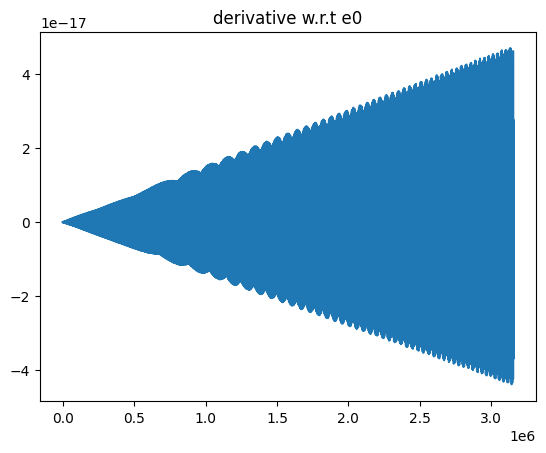

In [20]:
times = np.arange(len(der))*dt
plt.plot(times, der.real)
plt.title(f"derivative w.r.t {deriv_parameter}")
plt.show()

### Compare with finite difference derivative of the waveform itself

In [21]:
wave_gen_base = GenerateEMRIWaveform(
    FastKerrEccentricEquatorialFlux,
    mode_selector_kwargs=dict(mode_selection = waveform_derivative.cache['mode_selection']), 
    inspiral_kwargs=dict(err=1e-8, max_iter=10000)
    )

In [22]:
# compute the derivative manually
wavdelts = []

delt = delta_e0

for delta in [-2*delt, -delt, delt, 2*delt]:
    parameters_in = parameters.copy()
    parameters_in[deriv_parameter] += delta
    wave = wave_gen_base(
        parameters_in['m1'],
        parameters_in['m2'],
        parameters_in['a'],
        parameters_in['p0'],
        parameters_in['e0'],
        parameters_in['xI0'],
        parameters_in['dist'],
        parameters_in['qS'],
        parameters_in['phiS'],
        parameters_in['qK'],
        parameters_in['phiK'],
        Phi_phi0 = parameters_in['Phi_phi0'],
        Phi_theta0 = parameters_in['Phi_theta0'],
        Phi_r0 = parameters_in['Phi_r0'],
        dt=dt, 
        T=T,
    )
    if len(wave) < len(waveform_derivative.cache['waveform_source']):
        wave = np.concatenate(
            (wave, np.zeros((waveform_derivative.cache['waveform_source'].size - wave.size), dtype=wave.dtype)*np.nan),
            axis=0
        )
    else:
        wave = wave[:waveform_derivative.cache['waveform_source'].size]
    wavdelts.append(wave)

deriv_man = stencil_fun(wavdelts, delt)

plt.plot(times[:2000], der.real[0:2000])
plt.plot(times[:2000], deriv_man.real[0:2000], alpha=0.5)
plt.show()

plt.plot(times[:2000], der.imag[0:2000])
plt.plot(times[:2000], deriv_man.imag[0:2000], alpha=0.5)
plt.show()

plt.plot(der.real[20000:20500])
plt.plot(deriv_man.real[20000:20500], alpha=0.5)
plt.show()

# plt.plot(deriv_fast.real)
# plt.plot(deriv_man.real, alpha=0.5)
# plt.plot(deriv_fast.real-deriv_man.real)
# plt.plot(deriv.cache['waveform'].real, alpha=0.5)
# plt.xlim(300000, 301000)
# plt.xlim(110000, 111000)
# plt.xlim(3000, 6000)
# plt.ylim(-1e-18, 1e-18)

NameError: name 'delta_e0' is not defined